In [1]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### calc score

In [3]:
pbmc_anndata = sc.read_h5ad('../data/pbmc.virus.refine.7.h5ad')
pbmc_anndata

AnnData object with n_obs × n_vars = 1080252 × 12753
    obs: 'dataset', 'patients', 'patients_time', 'sex', 'age', 'tissue', 'Health', 'majorType', 'sampleID', 'patient_state', 'sample_state', 'BCR_ID', 'TCR_ID', 'state', 'celltype', 'source', 'n_genes', 'louvain_0.5', 'louvain_celltype', 'louvain_majorType', 'inflammatory', 'cytokine', 'louvain_celltype_index', 'louvain_celltype_index_name', 'inflammatory_cytokine'
    var: 'gene_name-covid19'
    uns: 'dataset_colors', 'leiden', 'louvain', 'louvain_celltype_colors', 'louvain_celltype_index_colors', 'louvain_celltype_index_name_colors', 'louvain_majorType_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'

In [ ]:
inflammatory_genes = open('/home/caipengfei/RNA_seq/nCov/virus/genesets/HALLMARK_INFLAMMATORY_RESPONSE.txt', 'r').readlines()
inflammatory_genes = [ item.strip('\n').strip() for item in inflammatory_genes]
inflammatory_genes_filtered = set(pbmc_anndata.var.index.values).intersection(inflammatory_genes)

cytokine_genens = open('/home/liunianping/workspace/projects/Virus/Cytokines_analysis/data/merged.cytokines.txt').readlines()
cytokine_genens = [ item.strip('\n').strip() for item in cytokine_genens]
cytokine_genens_filtered = set(pbmc_anndata.var.index.values).intersection(cytokine_genens)

merged_genes = list(inflammatory_genes_filtered.union(cytokine_genens_filtered))
len(merged_genes)

In [ ]:
sc.tl.score_genes(pbmc_anndata, gene_list=merged_genes, score_name='inflammatory_cytokine')

### show score

In [31]:
meta = pbmc_anndata.obs.copy()
covid19_meta = meta[meta.source.isin(['Covid19', 'Control'])]
hiv_meta = meta[meta.source.isin(['HIV', 'Control'])]
sepsis_meta = meta[meta.source.isin(['Sepsis', 'Control'])]

In [29]:
palette1=['#228B22','#DC78B4','#F54196','#fb9a99','#e31a1c']
_order1 = ['control','moderate convalescent','severe convalescent','moderate onset', 'severe onset']

palette2=['#228B22','#abcde5','#96c2de','#81b5d8','#6ca8d1','#579bca','#438ec4','#3680b4']
_order2 = ['control', '0 Weeks', '1 Week', '2 Weeks', '3 Weeks', '4 Weeks', '6 Months','1 Year']

palette3=['#228B22','#fdb97d',"#f7a160","#f28a43","#ed7226","#e15c0e"]
_order3 = ['control', 'Leuk-UTI', 'Int-URO', 'URO', 'Bac-SEP', 'ICU-SEP']

In [30]:
def draw_boxplot(df:pd.DataFrame,hue_order,palette,x='louvain_celltype',hue='state',
                 ylim=[-1.5, 3], figsize=(14, 5),path=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.boxplot(data=df, x=x, y='inflammatory_cytokine',hue=hue, fliersize=0, hue_order=hue_order,palette=palette,
                linewidth=0.4,ax=axes
               )
    axes.set_ylim(ylim)
    axes.set_ylabel('inflammatory score')
    axes.set_xlabel('')
    plt.xticks(rotation=90)
    
    axes.legend(loc='best', bbox_to_anchor=(0.7, 0., 0.5, 0.5))
    plt.subplots_adjust(bottom=0.45, hspace=0.06, right=0.85)
    if path:
        plt.savefig(path, dpi=100)

#### COVID-19

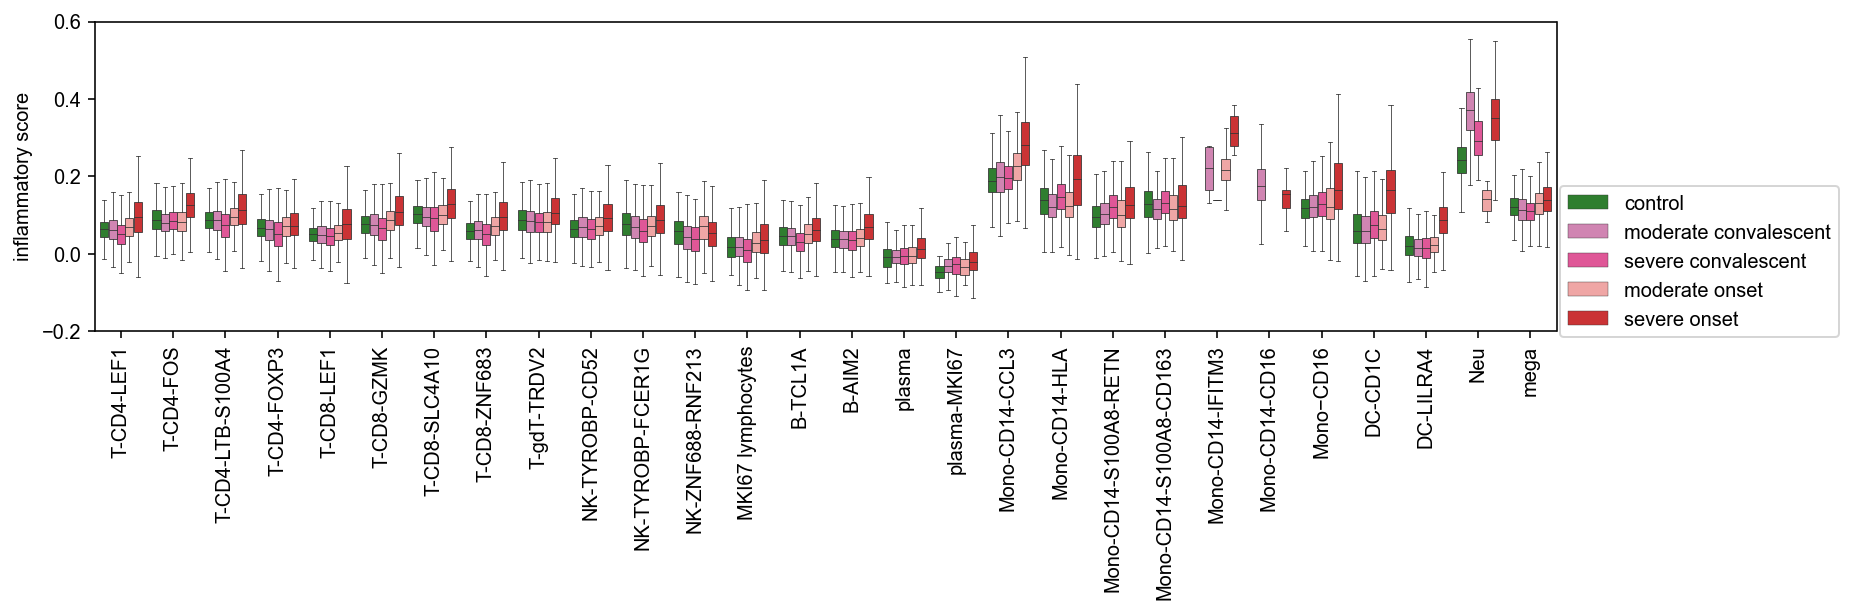

In [36]:
draw_boxplot(covid19_meta,ylim=[-.2, .6], palette=palette1, hue_order=_order1
             , path='./figures/score.covid19.pdf'
            )

#### HIV

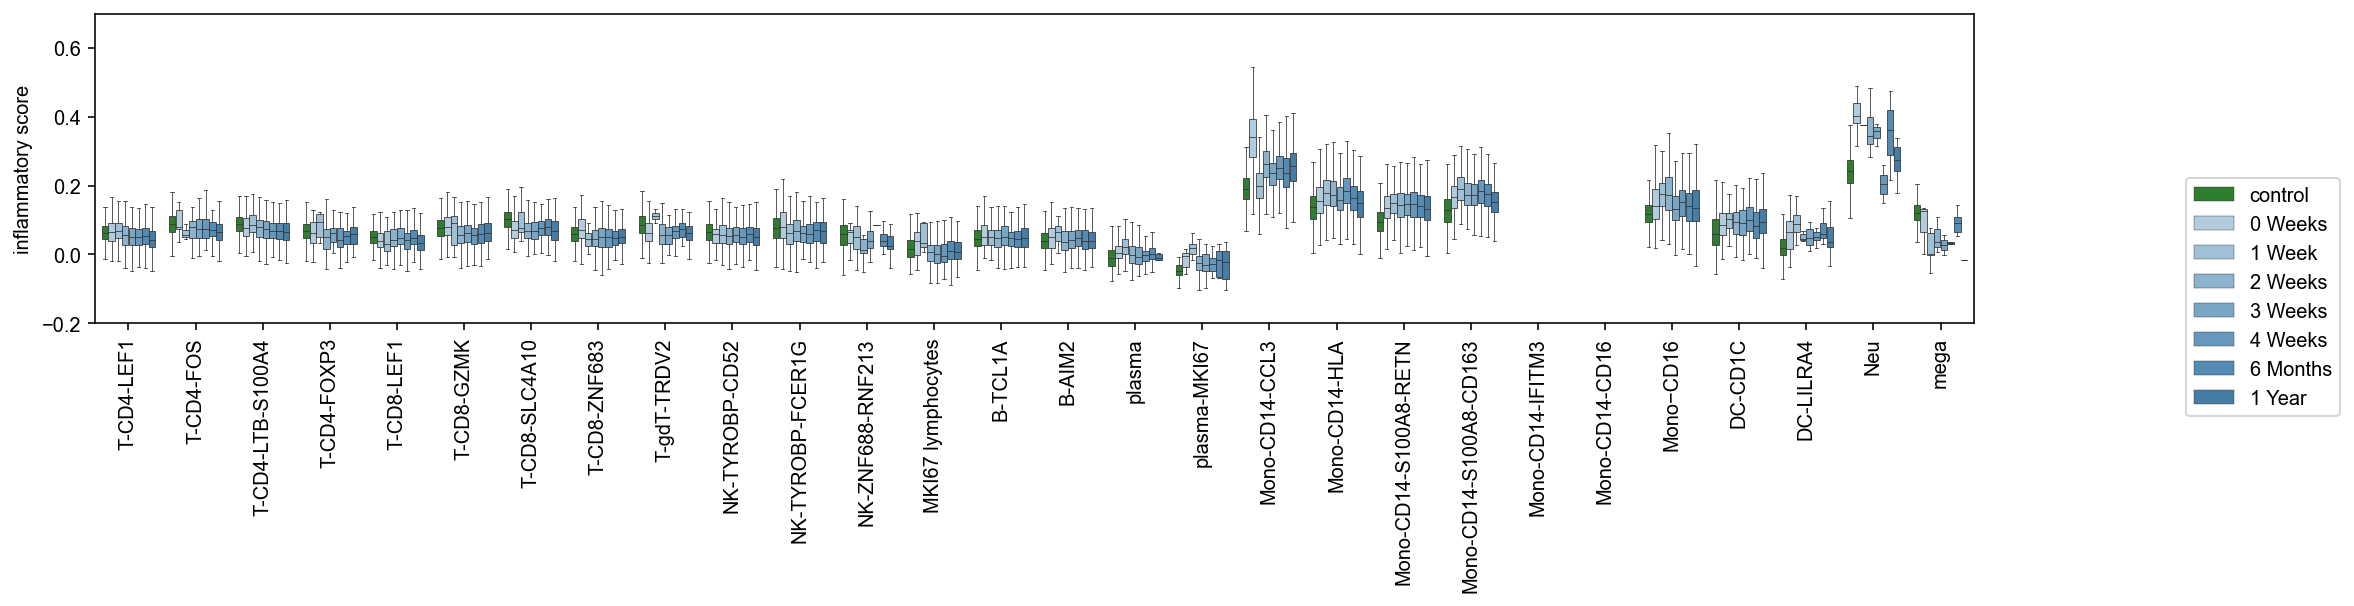

In [37]:
draw_boxplot(
    hiv_meta,hue='patients_time',
    hue_order=_order2,
    ylim=[-.2, .7],
    palette=palette2, figsize=(18, 5)
    , path='./figures/score.hiv.pdf'
)

#### sepsis

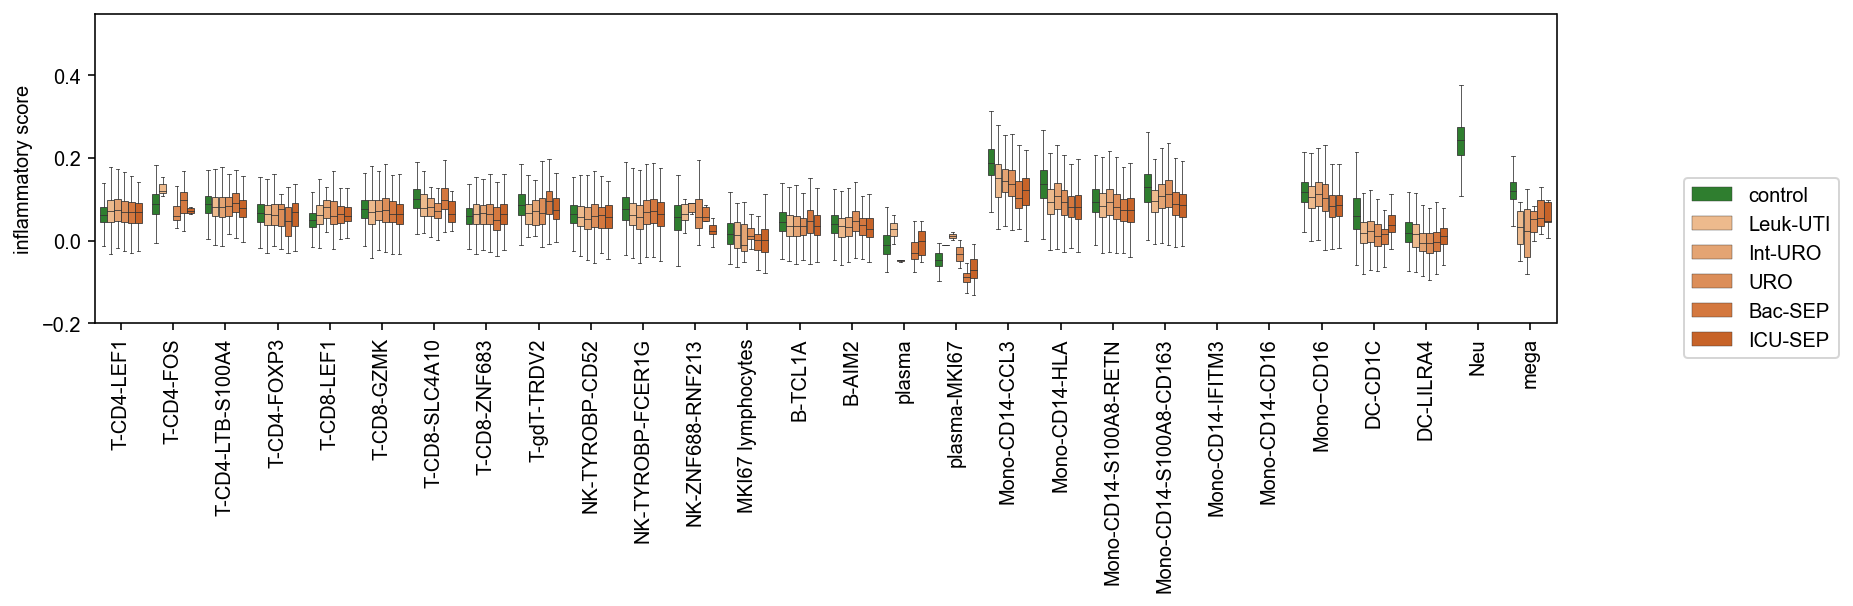

In [38]:
draw_boxplot(
    sepsis_meta, x='louvain_celltype',hue='patients_time',
    hue_order=_order3,
    palette=palette3,
    ylim=[-.2, .55], figsize=(14, 5),
    path='./figures/score.sepsis.pdf'
)

## Test

In [39]:
from scipy.stats import mannwhitneyu
def mannwhitneyu_test(score_meta, path=None):
    """
    one-tail test
    """
    result = []
    for _celltype in score_meta.louvain_celltype.unique().tolist():
        exp_group = score_meta[score_meta.louvain_celltype==_celltype]
        ctrl_group = score_meta[score_meta.louvain_celltype!=_celltype]
        
        _, _pval1 = mannwhitneyu(exp_group.inflammatory_cytokine, ctrl_group.inflammatory_cytokine,alternative='greater')
        result.append([_celltype, _pval1])
    PVAL_df = pd.DataFrame(result, columns=['celltype', 'pvalue'])
    if path:
        PVAL_df.to_csv(path)
    else:
        return PVAL_df

In [40]:
mannwhitneyu_test(covid19_meta, path='./figures/score.mannwhitneyu_test.covid19.csv')
mannwhitneyu_test(hiv_meta, path='./figures/score.mannwhitneyu_test.hiv.csv')
mannwhitneyu_test(sepsis_meta, path='./figures/score.mannwhitneyu_test.sepsis.csv')